In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP, SGLRP2, OAGLRP
from utils.helper import heatmap
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical
import math
import scipy.io as sio
import tqdm
from utils.fileutils import CacheStorage

os.environ["CUDA_VISIBLE_DEVICES"]="1"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
input_shape = (40, 40, 1)
num_classes = 10

In [3]:
def load_images_from_mat(data_dir):
    mat_list = os.listdir(data_dir)
    images = np.empty((0, input_shape[0]*input_shape[1]*input_shape[2]))
    labels = np.empty((0,num_classes))
    for mat_path in tqdm.tqdm(mat_list):
        if mat_path.endswith('.mat'):
            mat_contents = sio.loadmat(os.path.join(data_dir, mat_path))
            data = mat_contents['affNISTdata'][0,0]
            images = np.append(images, data['image'].T, axis=0)
            labels = np.append(labels, data['label_one_of_n'].T, axis=0)
    return images, labels
# load_images_from_mat(os.path.join('data', 'affMNIST','test'))

In [4]:
def get_affnist_images(data_dir, dataset):
    imgs = []
    labels = []

    cache = CacheStorage()
    print("Try to load cache file")
    imgs = cache.get_cache(os.path.join('cache', "mnist_imgs_"+dataset))
    labels = cache.get_cache(os.path.join('cache', "mnist_labels_"+dataset))
    if imgs is None or labels is None:
        print("Making cache file")
        imgs, labels = load_images_from_mat(os.path.join(data_dir, dataset))
        cache.set_cache(os.path.join('cache', "mnist_imgs_"+dataset), imgs)
        cache.set_cache(os.path.join('cache', "mnist_labels_"+dataset), labels)
    return imgs, labels

In [5]:
x_test, y_test = get_affnist_images(os.path.join('data', 'affMNIST'), 'test')
x_train, y_train = get_affnist_images(os.path.join('data', 'affMNIST'), 'training')

Try to load cache file
Try to load cache file


In [6]:
print(np.shape(x_train))

(1920000, 1600)


In [7]:
# This will be your trained model instead.

from utils.models import VGG10_nodrop, preprocess_input
model = VGG10_nodrop(
    input_shape=input_shape,
    nb_class=num_classes
)
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
__________

In [8]:
x_train = preprocess_input(x_train, input_shape[0], input_shape[1], input_shape[2])
x_test = preprocess_input(x_test, input_shape[0], input_shape[1], input_shape[2])

In [9]:
#train
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

nb_iterations = 50000
learning_rate=0.0001
batch_size=128
nb_epochs = math.ceil(nb_iterations * (batch_size / x_train.shape[0]))
dataset_prefix="affmnist"

save=True
train=True

validation_split=0.0001

if not os.path.exists(os.path.join("logs", "%s" % (dataset_prefix))):
    os.mkdir(os.path.join("logs", "%s" % (dataset_prefix)))
tensorboard = TensorBoard(log_dir=os.path.join("logs", "%s" % (dataset_prefix)), batch_size=batch_size)
csv_logger = CSVLogger(os.path.join('logs', '%s.csv' % (dataset_prefix)))

if not save:
    callback_list = []
else:
    callback_list = [tensorboard, csv_logger]
    #callback_list = [model_checkpoint, reduce_lr, tensorboard, csv_logger]


optm = Adam(lr=learning_rate)
model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])

if train:
    #train
    model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, callbacks=callback_list, verbose=1, validation_split=validation_split)
    if save:
        model.save_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))
else: 
        model.load_weights(os.path.join("weights", "%s_val_loss_weights_final.h5" % (dataset_prefix)))

Train on 1919808 samples, validate on 192 samples
Epoch 1/4
1919808/1919808 [==============================] - 13949s 7ms/step - loss: 0.0638 - acc: 0.9797 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 2/4
1919808/1919808 [==============================] - 15866s 8ms/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0115 - val_acc: 0.9948
Epoch 3/4
1919808/1919808 [==============================] - 13555s 7ms/step - loss: 0.0088 - acc: 0.9973 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 4/4
1919808/1919808 [==============================] - 13423s 7ms/step - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0264 - val_acc: 0.9896


In [10]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
__________

In [11]:
# Range of input images
# keras_applications VGG16 weights assume a range of (-127.5, 127.5). Change this to a range suitable for your model.
max_input = -1.
min_input = 1.

In [12]:
# Change this to load a list of images you want. For this example, we are only loading one image, but you can load a list of files.
orig_imgs = x_test
input_imgs = np.copy(orig_imgs[:200])
print(np.shape(input_imgs))


(200, 40, 40, 1)


In [13]:
# Select only one from your list for example
example_id = 0

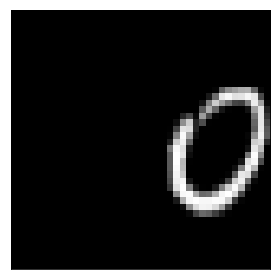

In [16]:
plt.imshow(orig_imgs[example_id].reshape((input_shape[0],input_shape[1])), cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [17]:
# GradCAM and GuidedGradCAM requires a specific layer
target_layer = "max_pooling2d_3" # VGG only

In [18]:
# Optional
predictions = model.predict(input_imgs)

In [ ]:
for i, p in enumerate(predictions):
    if np.max(p) < 1. :
        print(i, np.max(p))

In [19]:
# Which class you want to target.
target_class = 0

pred_id = np.argmax(predictions[example_id])
print("probability:", predictions[example_id][target_class])
print("prediction id:", pred_id)
print("target id:", target_class)

probability: 1.0
prediction id: 0
target id: 0


# GradCAM

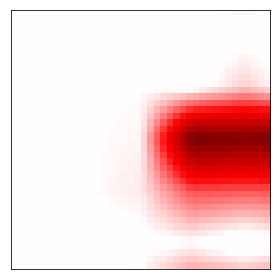

In [20]:
partial_gradcam_analyzer = GradCAM(
    model=partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_partial_grad_cam = partial_gradcam_analyzer.analyze(input_imgs)
heatmap(analysis_partial_grad_cam[example_id].sum(axis=(2)))
plt.show()

# Guided Back Propagation

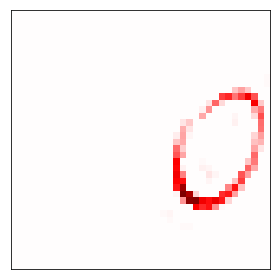

In [21]:
guidedbackprop_analyzer = GBP(
    partial_model,
    target_id=target_class,
    relu=True,
)
analysis_guidedbackprop = guidedbackprop_analyzer.analyze(input_imgs)
heatmap(analysis_guidedbackprop[example_id].sum(axis=(2)))
plt.show()

# GuidedGradCAM

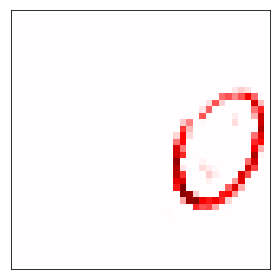

In [22]:
guidedgradcam_analyzer = GuidedGradCAM(
    partial_model,
    target_id=target_class,
    layer_name=target_layer,
    relu=True,
)
analysis_guidedgradcam = guidedgradcam_analyzer.analyze(input_imgs)
heatmap(analysis_guidedgradcam[example_id].sum(axis=(2)))
plt.show()

# LRP

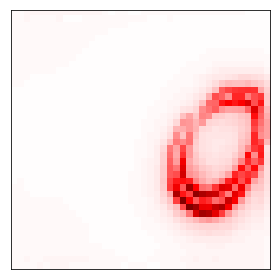

In [23]:
lrp_analyzer = LRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_lrp = lrp_analyzer.analyze(input_imgs)
heatmap(analysis_lrp[example_id].sum(axis=(2)))
plt.show()

# CLRP

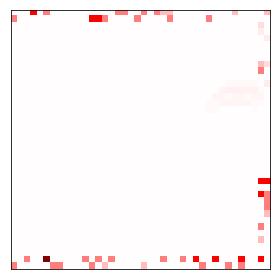

In [24]:
clrp_analyzer = CLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_clrp = clrp_analyzer.analyze(input_imgs)
heatmap(analysis_clrp[example_id].sum(axis=(2)))
plt.show()

# SGLRP

In [ ]:
sglrp_analyzer = SGLRP(
    partial_model,
    target_id=target_class,
    relu=True,
    low=min_input,
    high=max_input,
)
analysis_sglrp = sglrp_analyzer.analyze(input_imgs)
heatmap(analysis_sglrp[example_id].sum(axis=(2)))
plt.show()

In [ ]:
# oaglrp_analyzer = OAGLRP(
#     partial_model,
#     target_id=target_class,
#     relu=False,
#     scaling=False,
#     low=min_input,
#     high=max_input,
# )
# analysis_oaglrp = oaglrp_analyzer.analyze(input_imgs)
# heatmap(analysis_oaglrp[example_id].sum(axis=(2)))
# plt.show()